In [823]:
import numpy as np
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import scipy as sp
import os
#import scipy.io.wavfile as wav
from tempfile import TemporaryFile

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank

import aubio
from aubio import pvoc

from keras.preprocessing import sequence

In [556]:
def plotWave (y, pltLen):
    x = np.arange(pltLen)
    plt.plot(x,y[0:pltLen])
    plt.show()

In [877]:
def getBlocks (filename, label, win_s, sampleRate = 44100):
    hop_s = win_s // 2                                 # hop size
    fft_s = win_s // 2
    
    f = aubio.source(filename, sampleRate, win_s)
    samplerate = f.samplerate
    
    signal = np.zeros([win_s, 0], dtype="float32")
    
    total_frames, read = 0, f.hop_size
    while read:
        vec, read = f()
        total_frames += read
        signal = np.hstack( (signal, vec.reshape((len(vec), 1)) ) )
        #plotWave(fft, len(fft))
        
        if read < f.hop_size: break
    
    #compute 50% overlap 
    num_frames = signal.shape[1]
    signal_over = np.zeros([win_s , 2*num_frames-1], dtype=signal.dtype)
    sampled_label = np.zeros((label.shape[1], 2*num_frames-1), dtype=label.dtype)
    for i in range(signal.shape[1]):
        signal_over[:,2*i] = signal[:,i]
        sampled_label[:, 2*i] = label[i*(win_s-1), :]
        if (i==signal.shape[1]-1):
            break
        signal_over[0:win_s/2, 2*i+1] = signal[win_s/2:win_s, i]
        signal_over[win_s/2:win_s, 2*i+1] = signal[0:win_s/2, i+1]
        #sample label per frame
        sampled_label[:, 2*i+1] = label[i*(win_s-1) + win_s/2, :]
        
    #print(signal_over.shape)
    
    outstr = "read %.2fs" % (total_frames / float(samplerate))
    outstr += " (%d frames in" % total_frames
    outstr += " %d blocks" % (total_frames // f.hop_size)
    outstr += " at %dHz)" % f.samplerate
    outstr += " from " + f.uri
    print(outstr)
    
    return signal, signal_over, sampled_label, samplerate

In [878]:
def curtail(data, start, length):
    sizeAfterStart = len(data) - start
    if (sizeAfterStart < length):
        # pads zeros for short clips to avoid fft errors
        z = np.zeros(length - sizeAfterStart)
        #z = data[start: start + (length - sizeAfterStart)]
        data  = np.append(data, z)
    return data[start:start+length]

In [879]:
def minMaxNorm(data):
    MAX = np.amax(data)
    MIN = np.amin(data)
    return (data-MIN)/(MAX-MIN)

In [880]:
def getFFT (data, applyWin):
    #print(fftSize)
    blockSize = data.shape[0]
    
    if (applyWin):
        win = np.hamming(blockSize).reshape((blockSize, 1))
    else:
        win = np.ones((blockSize, 1))
        
    mult = np.multiply(data,win)
    fft = np.fft.rfft(mult, axis = 0, norm = "ortho") 
    magnitude = np.abs(fft)
    m = np.mean(magnitude)
    fftSpectrum = np.log10( magnitude + m*0.0001)
    
    # add minmaxnorm ??????
    
    #returnSpectrum = minMaxNorm(fftSpectrum)
    
    #print(fft.shape)
    return fftSpectrum

In [919]:
def melFeature (data, rate, fftSize):
    
    winlen = (fftSize*2.0)/rate
    ### Mel Features ###
    #win = np.hamming(fftSize*2)
    win = lambda x:np.hamming(x)
    
    mfcc_feat = mfcc(data, rate, nfft = fftSize, nfilt=40, numcep = 26, winfunc = win, winlen = winlen, winstep = winlen/2)
    deltas = delta(mfcc_feat, 2)
    
    log_bank = logfbank(data, rate, nfft = fftSize, nfilt=40, winlen = winlen, winstep = winlen/2)
    
    return mfcc_feat, log_bank

In [920]:
win_s = 1024

In [967]:
sampleCount = 0
featureList = np.empty((0,4),dtype='object')

allowed_rate = 44100

fileSearch = "808 Bass Key .wav"
dir_to_search = set(["Output_Audio", "Reaper3"]) #include directories to search in here

for root, dirs, files in os.walk(".", topdown=True):
    dirs[:] = [d for d in dirs if d in dir_to_search]
    
    wav_files = [ fi for fi in files if fi.endswith(fileSearch) or (fi.endswith(".wav") or fi.endswith(".WAV")) ]
    for name in wav_files:
        fullpath = os.path.join(root, name)
        
        label = np.load(os.path.join(root,"label_"+ name + ".npy"))
        
        audio, audio_overlap, label, rate = getBlocks(fullpath, label, win_s, allowed_rate)
    
        audio_vector = np.zeros((np.prod(audio.shape),))
        for i in range(audio.shape[1]):
            audio_vector[i*audio.shape[0]:(i+1)*audio.shape[0]] = audio[:,i]
        
    
        fft_time_series = getFFT(audio_overlap, True)
        mel_time_series, log_bank = melFeature(audio_vector.reshape((len(audio_vector),1)), allowed_rate, win_s/2)
        #mel_time_series = getMel(audio, allowed_rate, n_filters = 40, n_coeffs = 13)
        # truncate first mel coefficient
        log_bank = log_bank[:,1:]
        
        #print(featureList[1].shape)
        #print(np.expand_dims(label, axis=0).shape)
        
        #featureList[0] = np.vstack((featureList[0], name))
        #featureList[1] = np.vstack((featureList[1], np.expand_dims(label, axis=0)))
        #featureList[2] = np.vstack((featureList[2], np.expand_dims(fft_time_series, axis=0)))
        #featureList[3] = np.vstack((featureList[3], np.expand_dims(mel_time_series, axis=0)))
        
        vector = np.array([[name], [label], [np.transpose(fft_time_series)], [log_bank]], dtype='object')
        featureList = np.vstack((featureList, np.transpose(vector)))
    
        
        sampleCount += 1
        
    for name in dirs:
        sampleCount += 0 
        #print(os.path.join(root, name))


print("Sample Count")
print(sampleCount)
print("Feature List shape")
print(featureList.shape)

print('-------------Done Generating Features ----------------')

read 4.75s (209510 frames in 204 blocks at 44100Hz) from ./Output_Audio/Reaper3/Reaper3, 36-Pearl22Kick-5, LWFI_SNR_DRFL_HT_03, 41-Ludwig16FloorTom-2, ZDJN_HAT_O1FL_HT_015_03.wav
read 4.75s (209510 frames in 204 blocks at 44100Hz) from ./Output_Audio/Reaper3/Reaper3, JUST_kick_cyrax, L400_SNR_LEFL_HT_01, LWFI_SNR_OFFL_HT_02, ZDJN_HAT_C2FL_HT_015_03.wav
Sample Count
2
Feature List shape
(2, 4)
-------------Done Generating Features ----------------


In [968]:


label_list = [i.transpose().tolist() for i in featureList[:,1].tolist() ]
fft_list = [i.transpose().tolist() for i in featureList[:,2].tolist() ]
mel_list = [i.transpose().tolist() for i in featureList[:,3].tolist() ]

label_list_padded = sequence.pad_sequences(label_list, dtype=featureList[:,1].dtype, padding='post', value=0.)
fft_list_padded = sequence.pad_sequences(fft_list, dtype='float32', padding='post', value=0.)
mel_list_padded = sequence.pad_sequences(mel_list, dtype='float32', padding='post', value=0.)

print(label_list_padded.shape)
print(fft_list_padded.shape)
print(mel_list_padded.shape)

to_be_saved = np.empty((1,4),dtype='object')
to_be_saved[0,:] = [featureList[:,0], label_list_padded, fft_list_padded, mel_list_padded]


np.savez_compressed('data/time_series_normalized.npy', to_be_saved) # save compressed
    
"""
features_Mel[:,2].reshape(())

sequences = features_Mel.reshape(())
features = sequence.pad_sequences(sequences, dtype='float32', padding='post', value=0.)
print(features.shape)
"""

(2, 409, 8)
(2, 513, 409)
(2, 39, 409)


"\nfeatures_Mel[:,2].reshape(())\n\nsequences = features_Mel.reshape(())\nfeatures = sequence.pad_sequences(sequences, dtype='float32', padding='post', value=0.)\nprint(features.shape)\n"

In [969]:
def normalizeMFCC (mfcc):
    for i in range(mfcc.shape[1]):
        mean = np.mean(mfcc[:,i])
        std =  np.std (mfcc[:,i])
        mfcc[:,i] = np.subtract(mfcc[:,i], mean)/std
    return mfcc

Reaper3, 36-Pearl22Kick-5, LWFI_SNR_DRFL_HT_03, 41-Ludwig16FloorTom-2, ZDJN_HAT_O1FL_HT_015_03.wav
(409, 39)


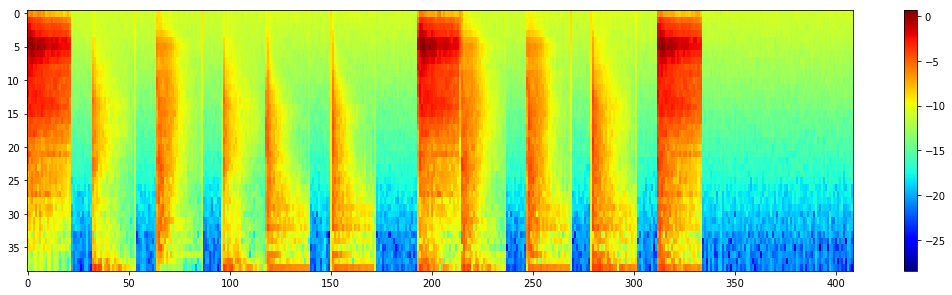

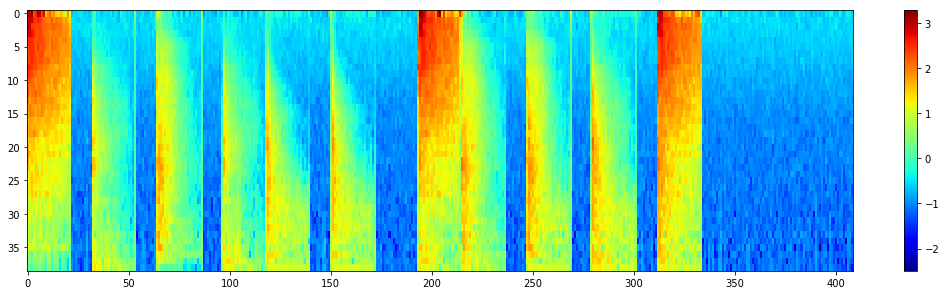

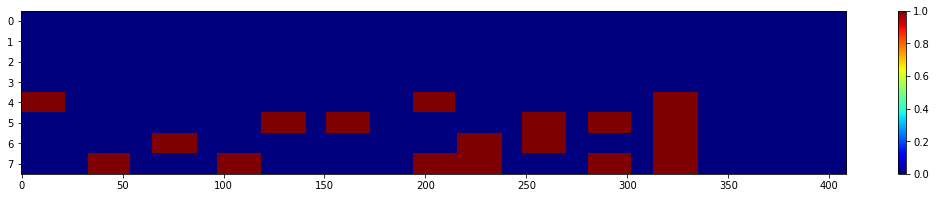

In [970]:
index = 0
sample = featureList[index,:]
s = sample[3]
print(sample[0])
print(s.shape)
colormap = 'jet'

fig = plt.gcf()
fig.set_size_inches(18.5, 4.8)
plt.imshow(np.flip(np.transpose(s[:,0:]), axis=0), cmap=colormap, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 4.8)
plt.imshow(np.flip(np.transpose(normalizeMFCC(s[:,0:])), axis=0), cmap=colormap, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 3)
plt.imshow(sample[1], cmap=colormap, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

Reaper3, 36-Pearl22Kick-5, LWFI_SNR_DRFL_HT_03, 41-Ludwig16FloorTom-2, ZDJN_HAT_O1FL_HT_015_03.wav
(409, 513)


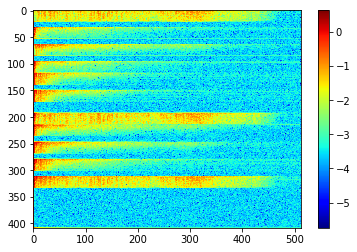

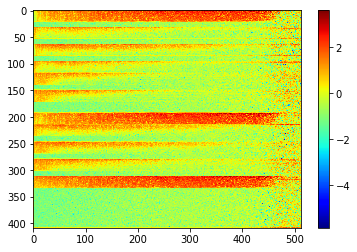

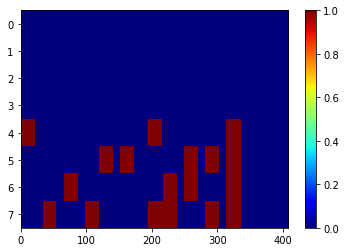

In [971]:
sample = featureList[index,:]
L = featureList[index,:]
s = sample[2]
print(sample[0])
print(s.shape)
plt.imshow(s[:,:], cmap='jet', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(normalizeMFCC(s[:,:]), cmap='jet', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(sample[1], cmap='jet', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()